In [1]:
import torch
import numpy as np
import time
import torch.nn as nn
import torch.nn.functional as f
import torch.utils.data as data
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.colors import to_rgba
import seaborn as sns

In [2]:
sns.set()

In [3]:
gpu = torch.cuda.is_available()
print(gpu)

True


In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
device

device(type='cuda')

In [6]:
x = torch.zeros(2, 3)
x = x.to(device)
print(x)

tensor([[0., 0., 0.],
        [0., 0., 0.]], device='cuda:0')


In [7]:
x = torch.randn(5000, 5000)

In [8]:
start_time = time.time()
_ = torch.matmul(x, x)
end_time = time.time()
print(f"CPU TIME  {(end_time - start_time):6.5f} ")

CPU TIME  3.23572 


In [9]:
x = x.to(device)

In [10]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
_ = torch.matmul(x, x)
end.record()
torch.cuda.synchronize()
print(f"GPU TIME  {0.001*start.elapsed_time(end):6.5f} ")

GPU TIME  2.34001 


In [11]:
class SimpleClassifier(nn.Module):
  
  def __init__(self, num_inputs, num_hidden, num_outputs):
    super().__init__()
    self.linear1 = nn.Linear(num_inputs, num_hidden)
    self.act_fn = nn.Tanh()
    self.linear2 = nn.Linear(num_hidden, num_outputs)
    
  def forward(self, x):
    x = self.linear1(x)
    x = self.act_fn(x)
    x = self.linear2(x)
    return x

In [12]:
model = SimpleClassifier(2, 4, 1)
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


In [13]:
for name, param in model.named_parameters():
  print(f"Parameters:{name}, shape{param.shape}")

Parameters:linear1.weight, shapetorch.Size([4, 2])
Parameters:linear1.bias, shapetorch.Size([4])
Parameters:linear2.weight, shapetorch.Size([1, 4])
Parameters:linear2.bias, shapetorch.Size([1])


In [14]:
class XORDataset(data.Dataset):
  def __init__(self, size, std = 0.2):
    super().__init__()
    self.size = size
    self.std = std
    self.generate_continuous_xor()
  
  def generate_continuous_xor(self):
    data = torch.randint(low = 0, high = 2, size = (self.size, 2), dtype = torch.float32)
    label = (data.sum(dim = 1) == 1).to(torch.long)
    data += self.std * torch.randn(data.shape)

    self.data = data
    self.label = label
  
  def __len__(self):
    return self.size

  def __getitem__(self, idx):
    data_point = self.data[idx]
    data_label = self.label[idx]

    return data_point, data_label

In [15]:
def visualize_samples(data, label):
  if isinstance(data, torch.Tensor):
    data = data.cpu().numpy()
  if isinstance(label, torch.Tensor):
    label = label.cpu().numpy()
  data_0 = data[label == 0]
  data_1 = data[label == 1]

  plt.figure(figsize = (6,6))
  plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label = "class 0")
  plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label = "class 1")
  plt.title("Dataset Samples")
  plt.ylabel(r"$X_2$")
  plt.xlabel(r"$X_1$")
  plt.show()

In [16]:
dataset = XORDataset(size = 2000)
print(len(dataset))
print(dataset[0])

2000
(tensor([ 0.7878, -0.1603]), tensor(1))


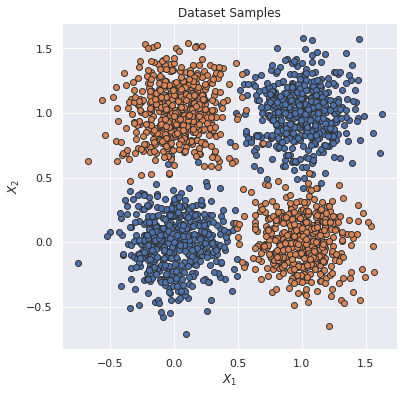

In [17]:
visualize_samples(dataset.data, dataset.label)
plt.show()

In [18]:
data_loader = data.DataLoader(dataset, batch_size = 8, shuffle = True)

In [19]:
data_inputs, data_labels = next(iter(data_loader))

In [20]:
print(data_inputs.shape)

torch.Size([8, 2])


In [21]:
loss_module = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)

In [22]:
train_dataset = XORDataset(2000)
data_loader = data.DataLoader(train_dataset, batch_size = 128, shuffle = True)

In [23]:
model.to(device)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [24]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs = 100):
  model.train()

  for epoch in tqdm(range(num_epochs)):
    for data_inputs, data_labels in data_loader:
      data_inputs = data_inputs.to(device)
      data_labels = data_labels.to(device)

      preds = model(data_inputs)
      preds = preds.squeeze(dim = 1)

      loss = loss_module(preds, data_labels.float())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

In [25]:
train_model(model, optimizer, data_loader, loss_module)

  0%|          | 0/100 [00:00<?, ?it/s]

In [26]:
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('linear1.weight', tensor([[-2.5305,  3.4943],
        [-3.3967,  2.2533],
        [-2.5479, -2.5347],
        [-0.9223, -0.8881]], device='cuda:0')), ('linear1.bias', tensor([ 1.0412, -0.8753,  0.9343,  1.3565], device='cuda:0')), ('linear2.weight', tensor([[-4.6693,  4.5684, -4.0314,  1.6430]], device='cuda:0')), ('linear2.bias', tensor([1.4477], device='cuda:0'))])


In [56]:
torch.save(state_dict, './config.txt')

In [27]:
test_dataset = XORDataset(size = 500)
test_data_loader = data.DataLoader(test_dataset, batch_size = 128, shuffle = False, drop_last = False)

In [28]:
def eval_model(model, data_loader):
  model.eval()
  true_preds, num_preds  = 0., 0.
  
  with torch.no_grad():
    for data_inputs, data_labels in data_loader:
      data_inputs = data_inputs.to(device)
      data_labels = data_labels.to(device)

      preds = model(data_inputs)
      preds = preds.squeeze(dim = 1)
      preds = torch.sigmoid(preds)
      preds_labels = (preds>=0.5).long()

      true_preds += (preds_labels == data_labels).sum()

      num_preds += data_labels.shape[0]

  acc = true_preds / num_preds
  print(f"Accuracy of the model: {100.0*acc:4.2f}")

In [29]:
eval_model(model, data_loader)

Accuracy of the model: 98.00


In [50]:
def visualize_classification(model, data, label):
  if isinstance(data, torch.Tensor):
    data = data.cpu().numpy()
  if isinstance(label, torch.Tensor):
    label = label.cpu().numpy()
  data_0 = data[label == 0]
  data_1 = data[label == 1]
  
  fig = plt.figure(figsize = (4, 4), dpi = 100)
  plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor = "#333", label = "class 0")
  plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor = "#333", label = "class 1")
  plt.title("Dataset Samples")
  plt.ylabel(r"$X_2$")
  plt.xlabel(r"$X_1$")
  # plt.legend(['0','1'], loc = 'upper left')

  model.to(device)
  c0 = torch.Tensor(to_rgba("C0")).to(device)
  c1 = torch.Tensor(to_rgba("C1")).to(device)

  x1 = torch.arange(-0.5, 1.5, step = 0.01, device = device)
  x2 = torch.arange(-0.5, 1.5, step = 0.01, device = device)

  xx1, xx2 = torch.meshgrid(x1, x2)
  model_inputs = torch.stack([xx1, xx2], dim = -1)
  preds = model(model_inputs)
  preds = torch.sigmoid(preds)
  output_image = (1 - preds) * c0[None, None] + preds * c1[None, None]
  output_image = output_image.cpu().detach().numpy()
  plt.imshow(output_image, origin = 'lower', extent = (-0.5, 1.5, -0.5, 1.5))
  plt.grid(False)
  # return fig

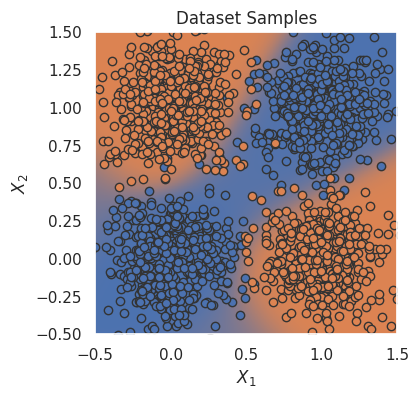

In [51]:
visualize_classification(model, dataset.data, dataset.label)